In [1]:
#include autoreload modules for fast testing and update
%load_ext autoreload
%autoreload 2

#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sbn
import time

#import modules
from src.data.helper_closed_transactions import read_epex_file, filter_lead_time, extract_transactions
from src.visualization.visualize_transactions import executed_transactions_bar_chart, executed_transactions_heatmap_summary, executed_transactions_time_series

#set maximum columns display pandas
pd.options.display.max_columns = 50
import glob
from tqdm import tqdm

### Reading with built functions

In [2]:
tic = time.time()
df=read_epex_file(
    "../data/external/EPEX_spot_continous_2019/DE Continuous Orders 2019-04/DE Continuous Orders 20190403.csv",
    fast_load=False)
toc = time.time()

In [3]:
print(f'Reading and processing one file with new method completely takes {toc-tic} seconds')

Reading and processing one file with new method completely takes 25.88260316848755 seconds


## Global Investigation of lead time hourly contracts

In [22]:

is_type=[]
for filepath in glob.glob('../data/processed/EPEX_spot_continous_complete_pipeline_2019_14-04-2021 16:04:00'+'/*/*/DE*.csv', recursive=True):

    #### Daily Transaction Derivation ####

    # loading the daily csv file at day
    df = pd.read_csv(filepath)
    is_type.append(df['Instrument Type'].unique())
    
    

In [24]:
len(is_type)

300

### Investigating volumes transactions

In [2]:
df_pure=pd.read_csv("../data/external/EPEX_spot_continous_2019/DE Continuous Orders 2019-04/DE Continuous Orders 20190403.csv",
                    sep=';',
                    decimal=",",)

In [21]:
df_pure.head()

,Order ID,Initial ID,Parent ID,Start Validity Date,End Validity Date,Cancelling Date,Delivery Date,Instrument Type,Delivery Instrument,Is block,Area,Side,Price,Volume,Is Executed,Execution Price,Executed Volume,Unnamed: 17
0,10392237500,10392237500,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-50Hz,B,25.36,2.5,0,NaN,0.0,NaN
1,10392237501,10392237501,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-50Hz,S,55.36,2.5,0,NaN,0.0,NaN
2,10392237502,10392237502,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-AMP,B,25.40,0.2,0,NaN,0.0,NaN
3,10392237503,10392237503,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-AMP,S,55.40,0.2,0,NaN,0.0,NaN
4,10392237504,10392237504,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-TPS,B,25.36,2.5,0,NaN,0.0,NaN


Independently of lead time check data differences.

In [49]:
df_pure['Delivery Instrument_mod']=pd.to_timedelta(df_pure['Delivery Instrument'].apply(lambda x: x + ':00'))

In [62]:
df_pure['Delivery Instrument_hour']=df_pure['Delivery Instrument_mod'].dt.seconds/3600

In [63]:
df_pure['Delivery Instrument_hour']=df_pure['Delivery Instrument_hour'].astype('float')

In [64]:
# df_pure_ordered=df_pure.set_index('Delivery Instrument_hour')

In [77]:
df_pure_ord=df_pure.sort_values(by=['Delivery Instrument_hour'], ascending=True)

In [86]:
df_pure_ord['End Validity Date']=pd.to_datetime(df_pure_ord['End Validity Date'],
                                               utc=True,
                                                format='%d/%m/%Y %H:%M:%S.%f')

In [88]:
df_pure_ord[(df_pure_ord['Delivery Instrument_hour']>=18)&
            (df_pure_ord['Is Executed']!=0)&
           (df_pure_ord['End Validity Date'].dt.hour>=17)].head(60)

,Order ID,Initial ID,Parent ID,Start Validity Date,End Validity Date,Cancelling Date,Delivery Date,Instrument Type,Delivery Instrument,Is block,Area,Side,Price,Volume,Is Executed,Execution Price,Executed Volume,Unnamed: 17,Delivery Instrument_mod,Delivery Instrument_hour
523923,10392939602,10392939602,NaN,03/04/2019 17:28:09.978,2019-04-03 17:28:09.978000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-TPS,S,55.00,0.500,1,55.00,0.500,NaN,0 days 18:00:00,18.0
526683,10392942397,10392942397,NaN,03/04/2019 17:32:11.167,2019-04-03 17:32:11.167000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-TPS,S,55.00,0.300,1,55.00,0.300,NaN,0 days 18:00:00,18.0
526725,10392942439,10392942439,NaN,03/04/2019 17:32:14.501,2019-04-03 17:32:14.501000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,S,53.50,0.075,1,53.50,0.075,NaN,0 days 18:00:00,18.0
525862,10392941547,10392941547,NaN,03/04/2019 17:31:06.803,2019-04-03 17:31:06.803000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,S,53.50,0.250,1,53.50,0.250,NaN,0 days 18:00:00,18.0
525792,10392941472,10392936230,1.039294e+10,03/04/2019 17:31:01.623,2019-04-03 17:31:06.803000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,B,53.50,0.325,2,53.50,0.250,NaN,0 days 18:00:00,18.0
525793,10392941472,10392936230,1.039294e+10,03/04/2019 17:31:06.803,2019-04-03 17:32:14.501000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,B,53.50,0.075,1,53.50,0.075,NaN,0 days 18:00:00,18.0
525748,10392941440,10392941440,NaN,03/04/2019 17:31:00.109,2019-04-03 17:32:11.167000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-TPS,B,55.00,0.300,1,55.00,0.300,NaN,0 days 18:00:00,18.0
525781,10392941471,10392934776,1.039294e+10,03/04/2019 17:31:01.623,2019-04-03 17:34:22.349000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,S,54.90,1.200,2,54.90,0.625,NaN,0 days 18:00:00,18.0
517958,10392933271,10392933271,NaN,03/04/2019 17:14:56.102,2019-04-03 17:14:56.102000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-TPS,B,51.50,0.275,1,51.50,0.275,NaN,0 days 18:00:00,18.0
517436,10392932821,10392932821,NaN,03/04/2019 17:13:44.804,2019-04-03 17:14:00.467000+00:00,NaN,03/04/2019,Quarter Hour,18:00,N,DE-50Hz,B,48.60,2.250,2,48.60,0.050,NaN,0 days 18:00:00,18.0


In [5]:
df['Instrument Type'].value_counts()

Quarter Hour    385180
Hour            270082
Half Hour         1320
Name: Instrument Type, dtype: int64

In [6]:
df[df['Instrument Type']=='Hour']['lead_time'].min()

Timedelta('0 days 01:05:00.253000')

In [7]:
df[(df['Is Executed']!=0)&(df['Side']=='S')]['Volume'].sum()

302131.25

In [8]:
df_filtered=filter_lead_time(df)

In [9]:
df_filtered[(df['Is Executed']!=0)&(df['Side']=='S')]['Volume'].sum()

<ipython-input-9-e808ed3ad7bd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered[(df['Is Executed']!=0)&(df['Side']=='S')]['Volume'].sum()


12224.100000000002

Comparing 12224 with 21938 there seems to be difference.

In [6]:
df_filtered['Instrument Type'].value_counts()

Quarter Hour    19114
Name: Instrument Type, dtype: int64

Compare derived transactions with transactions from Alpiq

In [83]:
df_transactions=pd.read_csv('../data/processed/EPEX_spot_continous_complete_pipeline_2019_09-04-2021 18:39:55/2019-04/Updated Transactions/DE_20190403.csv')

In [35]:
df_transactions.head()

,index,End Validity Date,Executed Price & Volume,Delivery Start,Executed Volume,Execution Price,Initial ID_B,Instrument Type,Is Executed_B,Is block_B,Order ID_B,Parent ID_B,Price_B,Volume_B,index_B,lead_time_B,Initial ID_S,Is Executed_S,Is block_S,Order ID_S,Parent ID_S,Price_S,Volume_S,index_S,lead_time_S,weekly_hydro_marginal_price_selling,weekly_hydro_marginal_price_pumping,possible_match_selling,possible_match_pumping,match_binary_outcome_pumping,match_binary_outcome_selling,A posteriori Execution Price
0,1,2019-04-02 23:15:06.234000+00:00,"(51.7, 0.025)",2019-04-03 00:15:00+00:00,0.025,51.70,10392470684,Quarter Hour,1,N,10392470996,1.039247e+10,51.70,0.025,56488,0 days 00:59:54.075000,10392471002,2,N,10392471002,NaN,50.21,4.750,56492,0 days 00:59:53.766000,43.469349,30.428544,True,False,0,2,51.70
1,0,2019-04-02 23:15:06.234000+00:00,"(50.55, 0.425)",2019-04-03 00:15:00+00:00,0.425,50.55,10392470901,Quarter Hour,1,N,10392470975,1.039247e+10,50.55,0.425,56473,0 days 00:59:55.548000,10392471002,2,N,10392471002,NaN,50.21,4.725,56493,0 days 00:59:53.766000,43.469349,30.428544,True,False,0,2,50.55
2,2,2019-04-02 23:15:33.565000+00:00,"(50.21, 0.075)",2019-04-03 00:15:00+00:00,0.075,50.21,10392470656,Quarter Hour,2,N,10392471406,1.039247e+10,51.21,1.250,56808,0 days 00:59:26.435000,10392471002,1,N,10392471002,NaN,50.21,0.075,56495,0 days 00:59:53.766000,43.469349,30.428544,True,False,0,2,50.21
3,3,2019-04-02 23:15:37.732000+00:00,"(52.1, 0.1)",2019-04-03 00:15:00+00:00,0.100,52.10,10392470656,Quarter Hour,2,N,10392471467,1.039247e+10,53.10,1.250,56855,0 days 00:59:22.268000,10392467879,1,N,10392471125,1.039247e+10,52.10,0.100,56591,0 days 00:59:47.331000,43.469349,30.428544,True,False,0,2,52.10
4,4,2019-04-02 23:15:43.343000+00:00,"(55.05, 0.575)",2019-04-03 00:15:00+00:00,0.575,55.05,10392470656,Quarter Hour,2,N,10392471533,1.039247e+10,56.05,1.250,56917,0 days 00:59:16.657000,10392470902,1,N,10392471486,1.039247e+10,55.05,0.575,56884,0 days 00:59:21.184000,43.469349,30.428544,True,False,0,2,55.05


In [36]:
df_transactions['Executed Volume'].sum()

6182.175000000001

In [ ]:
df_transactions

The orders ID do not match with those given by Aurelio's file

- IDs are different --> datasets seem to be different since xbid products are also present in Aurelio's datasets
- We do not have hourly products in our derived transactions
- Are all the rows of the excel file of aurelio already filtered for lead time????? If yes there is a difference in the data clearly


### Comparison for Aurelio of Hourly Contracts

In [2]:
df_pure=pd.read_csv("../data/external/EPEX_spot_continous_2019/DE Continuous Orders 2019-04/DE Continuous Orders 20190403.csv",
                    sep=';',
                    decimal=",",)

In [4]:
df_pure

,Order ID,Initial ID,Parent ID,Start Validity Date,End Validity Date,Cancelling Date,Delivery Date,Instrument Type,Delivery Instrument,Is block,Area,Side,Price,Volume,Is Executed,Execution Price,Executed Volume,Unnamed: 17
0,10392237500,10392237500,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-50Hz,B,25.36,2.500,0,NaN,0.000,NaN
1,10392237501,10392237501,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-50Hz,S,55.36,2.500,0,NaN,0.000,NaN
2,10392237502,10392237502,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-AMP,B,25.40,0.200,0,NaN,0.000,NaN
3,10392237503,10392237503,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-AMP,S,55.40,0.200,0,NaN,0.000,NaN
4,10392237504,10392237504,NaN,02/04/2019 15:00:02.206,02/04/2019 18:00:00.001,02/04/2019 18:00:00.000,03/04/2019,Hour,09:00,N,DE-TPS,B,25.36,2.500,0,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656577,10393119720,10393119720,NaN,03/04/2019 23:37:37.249,03/04/2019 23:40:00.000,03/04/2019 23:40:00.000,03/04/2019,Quarter Hour,24:00,N,DE-50Hz,B,7.10,0.075,0,NaN,0.000,NaN
656578,10393120178,10393120178,NaN,03/04/2019 23:38:40.278,03/04/2019 23:39:29.935,03/04/2019 23:39:29.937,03/04/2019,Quarter Hour,24:00,N,DE-50Hz,B,33.00,0.075,0,NaN,0.000,NaN
656579,10393120567,10393120178,1.039312e+10,03/04/2019 23:39:29.935,03/04/2019 23:39:29.935,NaN,03/04/2019,Quarter Hour,24:00,N,DE-50Hz,B,45.00,0.075,1,43.98,0.075,NaN
656580,10393120582,10393114014,1.039312e+10,03/04/2019 23:39:32.518,03/04/2019 23:40:00.000,03/04/2019 23:40:00.000,03/04/2019,Quarter Hour,24:00,N,DE-50Hz,B,12.01,0.250,0,NaN,0.000,NaN


In [7]:
df_pure[(df_pure['Instrument Type']=='Hour')&(df_pure['Is Executed']!=0)].to_csv('../comparison_dataset.csv')

In [8]:
df_pure[(df_pure['Instrument Type']=='Hour')&(df_pure['Is Executed']!=0)]

,Order ID,Initial ID,Parent ID,Start Validity Date,End Validity Date,Cancelling Date,Delivery Date,Instrument Type,Delivery Instrument,Is block,Area,Side,Price,Volume,Is Executed,Execution Price,Executed Volume,Unnamed: 17
105,10392237662,10392237662,NaN,02/04/2019 15:00:05.874,02/04/2019 15:24:06.195,NaN,03/04/2019,Hour,11:00,N,DE-50Hz,S,47.51,2.5,1,47.51,2.5,NaN
107,10392237664,10392237664,NaN,02/04/2019 15:00:05.874,02/04/2019 15:23:50.575,NaN,03/04/2019,Hour,11:00,N,DE-AMP,S,47.50,0.1,1,47.50,0.1,NaN
109,10392237699,10392237699,NaN,02/04/2019 15:00:07.191,02/04/2019 15:24:06.195,NaN,03/04/2019,Hour,11:00,N,DE-TPS,S,47.51,2.5,1,47.51,2.5,NaN
111,10392237701,10392237701,NaN,02/04/2019 15:00:07.191,02/04/2019 15:23:50.575,NaN,03/04/2019,Hour,11:00,N,DE-TPS,S,47.50,0.2,1,47.50,0.2,NaN
113,10392237703,10392237703,NaN,02/04/2019 15:00:07.191,02/04/2019 15:23:50.575,NaN,03/04/2019,Hour,11:00,N,DE-ENBW,S,47.50,0.1,1,47.50,0.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652391,10393101658,10393101277,1.039310e+10,03/04/2019 22:54:05.699,03/04/2019 22:54:51.334,NaN,03/04/2019,Hour,24:00,N,DE-AMP,B,35.02,10.0,1,35.02,10.0,NaN
652411,10393101693,10393098981,1.039310e+10,03/04/2019 22:54:17.800,03/04/2019 22:54:58.198,NaN,03/04/2019,Hour,24:00,N,DE-50Hz,S,39.99,4.5,2,39.99,3.2,NaN
652442,10393101781,10393101781,NaN,03/04/2019 22:54:51.334,03/04/2019 22:54:51.334,NaN,03/04/2019,Hour,24:00,N,DE-AMP,S,35.00,13.2,2,35.02,10.0,NaN
652443,10393101781,10393101781,NaN,03/04/2019 22:54:51.334,03/04/2019 22:54:51.334,NaN,03/04/2019,Hour,24:00,N,DE-AMP,S,35.00,3.2,1,35.00,3.2,NaN


In [8]:
df_pure[(df_pure['Instrument Type']=='Half Hour')&(df_pure['Is Executed']!=0)]['Delivery Instrument'].max()

'22:30'

In [9]:
df_pure['Delivery Instrument'] = pd.to_timedelta(df_pure['Delivery Instrument'].apply(lambda x: x + ':00'))

In [10]:
def format_delta(instrument_type_duration, delivery_instrument):
    
    if instrument_type_duration=='Hour':
        return delivery_instrument-pd.Timedelta(1, unit='hours')
    elif instrument_type_duration=='Half Hour':
        return delivery_instrument-pd.Timedelta(0.5, unit='hours')
    else:
        return delivery_instrument-pd.Timedelta(0.25, unit='hours')

In [11]:
df_pure['Delivery Instrument']=df_pure.apply(lambda x: format_delta(x['Instrument Type'],x['Delivery Instrument']), axis=1) 

In [16]:
df_pure[(df_pure['Instrument Type']=='Hour')&(df_pure['Is Executed']!=0)]['Delivery Instrument'].min()

Timedelta('0 days 00:00:00')

## Volume analysis on newly computed april volumes

In [2]:
df_summary=pd.read_csv("../data/processed/summary_analysis_complete_window_interest_2019_17-04-2021 18:38:10/2019_17-04-2021 18:38:10_summary.csv",)

In [3]:
df_summary.head()

,time,Avg Historical Price,Max Historical Price,Avg a Posteriori Price,Max a Posteriori Price,Avg a Posteriori Price CH-DE,Max a Posteriori Price CH-DE,Avg a Posteriori Price DE-CH,Max a Posteriori Price DE-CH,Total Volume Traded,Total Volume Traded CH-DE,Total Volume Traded DE-CH,CH-DE Revenue Max,CH-DE Revenue Min,DE-CH Revenue Max,DE-CH Revenue Min,Number of Contracts Closed,CH-DE Additional Contracts Closed,DE-CH Additional Contracts Closed,Hours Count,Hours Match Count
0,2019-03-27,36.540880,59.78,36.139291,59.78,36.027204,59.78,36.652967,59.78,66426.275,8464.000,1969.625,397434.5510,356053.295156,55213.52050,57999.058368,25945,2977,1277,"{13: 2270, 0: 2241, 12: 1916, 10: 1712, 11: 14...","{7: 748, 18: 571, 8: 462, 6: 355, 20: 338, 10:..."
1,2019-03-28,40.008198,180.00,38.099453,180.00,38.023588,180.00,40.084062,180.00,45113.300,13628.750,1275.825,641393.2035,573317.739408,36344.41625,37568.902021,23585,8046,818,"{11: 2314, 12: 1925, 13: 1858, 10: 1767, 23: 1...","{15: 1173, 14: 903, 8: 822, 16: 799, 6: 678, 1..."
2,2019-03-29,34.933323,200.00,34.800052,180.00,34.338738,180.00,35.394637,200.00,45772.550,7534.825,7497.650,344339.5085,316965.887248,208193.39100,220781.438078,25588,3912,4098,"{8: 2599, 10: 1884, 9: 1612, 12: 1601, 11: 144...","{8: 866, 18: 756, 14: 735, 10: 581, 11: 560, 2..."
3,2019-03-30,34.617947,180.00,34.986174,180.00,33.669198,180.00,35.934923,180.00,34536.400,7037.325,10889.975,330348.8455,296037.660129,266506.23700,320674.390127,19548,3650,4686,"{8: 1331, 15: 1312, 18: 1166, 10: 1075, 9: 107...","{18: 1155, 14: 748, 20: 736, 15: 735, 8: 716, ..."
4,2019-03-31,22.145193,143.66,30.106594,128.80,21.944553,128.80,30.307234,143.66,46960.250,3293.275,31881.800,148331.8855,138537.501843,553309.75425,938815.449178,19015,1174,11243,"{0: 1665, 19: 1638, 18: 1581, 17: 1177, 23: 10...","{0: 1158, 23: 971, 13: 849, 18: 832, 10: 763, ..."


In [5]:
df_summary[pd.to_datetime(df_summary['time']).dt.month==4]['Total Volume Traded'].sum()

1515720.075

In [2]:
df_updated_transactions=pd.read_csv("../data/processed/EPEX_spot_continous_complete_pipeline_2019_17-04-2021 18:38:10/2019-04/Updated Transactions/DE_20190415.csv",)

In [19]:
df_updated_transactions.head()

,index,End Validity Date,Executed Price & Volume,Delivery Start,Executed Volume,Execution Price,Initial ID_B,Instrument Type,Is Executed_B,Is block_B,Order ID_B,Parent ID_B,Price_B,Volume_B,index_B,lead_time_B,Initial ID_S,Is Executed_S,Is block_S,Order ID_S,Parent ID_S,Price_S,Volume_S,index_S,lead_time_S,weekly_hydro_marginal_price_selling,weekly_hydro_marginal_price_pumping,possible_match_selling,possible_match_pumping,match_binary_outcome_pumping,match_binary_outcome_selling,A posteriori Execution Price
0,0,2019-04-14 23:00:02.571000+00:00,"(62.6, 0.625)",2019-04-15 00:00:00+00:00,0.625,62.6,10399126180,Quarter Hour,1,N,10399126218,1.039913e+10,65.73,0.625,43412,0 days 00:59:57.429000,10399126217,2,N,10399126217,NaN,62.6,1.0,43410,0 days 00:59:57.438000,46.131396,32.291977,True,False,0,2,62.6
1,3,2019-04-14 23:00:29.724000+00:00,"(40.0, 0.8)",2019-04-15 00:00:00+00:00,0.800,40.0,10399126475,Hour,1,N,10399126475,NaN,40.00,0.800,43585,0 days 00:59:30.276000,10399126332,1,N,10399126413,1.039913e+10,40.0,0.8,43539,0 days 00:59:41.449000,46.131396,32.291977,False,False,0,0,40.0
2,4,2019-04-14 23:00:29.724000+00:00,"(40.0, 0.8)",2019-04-15 00:00:00+00:00,0.800,40.0,10399126475,Hour,1,N,10399126475,NaN,40.00,0.800,43585,0 days 00:59:30.276000,10399126334,1,N,10399126449,1.039913e+10,40.0,0.8,43565,0 days 00:59:36.003000,46.131396,32.291977,False,False,0,0,40.0
3,2,2019-04-14 23:00:29.724000+00:00,"(40.0, 0.8)",2019-04-15 00:00:00+00:00,0.800,40.0,10399126475,Hour,2,N,10399126475,NaN,40.00,1.600,43584,0 days 00:59:30.276000,10399126334,1,N,10399126449,1.039913e+10,40.0,0.8,43565,0 days 00:59:36.003000,46.131396,32.291977,False,False,0,0,40.0
4,5,2019-04-14 23:00:29.724000+00:00,"(40.0, 20.0)",2019-04-15 00:00:00+00:00,20.000,40.0,10399126475,Hour,2,N,10399126475,NaN,40.00,21.600,43583,0 days 00:59:30.276000,10399126409,1,N,10399126409,NaN,40.0,20.0,43536,0 days 00:59:42.297000,46.131396,32.291977,False,False,0,0,40.0


In [20]:
df_updated_transactions[df_updated_transactions['Instrument Type']=='Hour']['Executed Volume'].sum()

48676.3

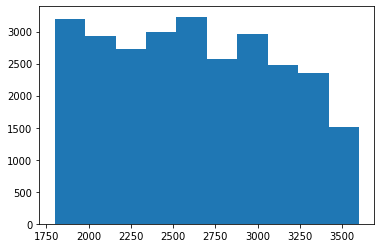

In [5]:
bins=plt.hist(pd.to_timedelta(df_updated_transactions['lead_time_S']).dt.seconds)

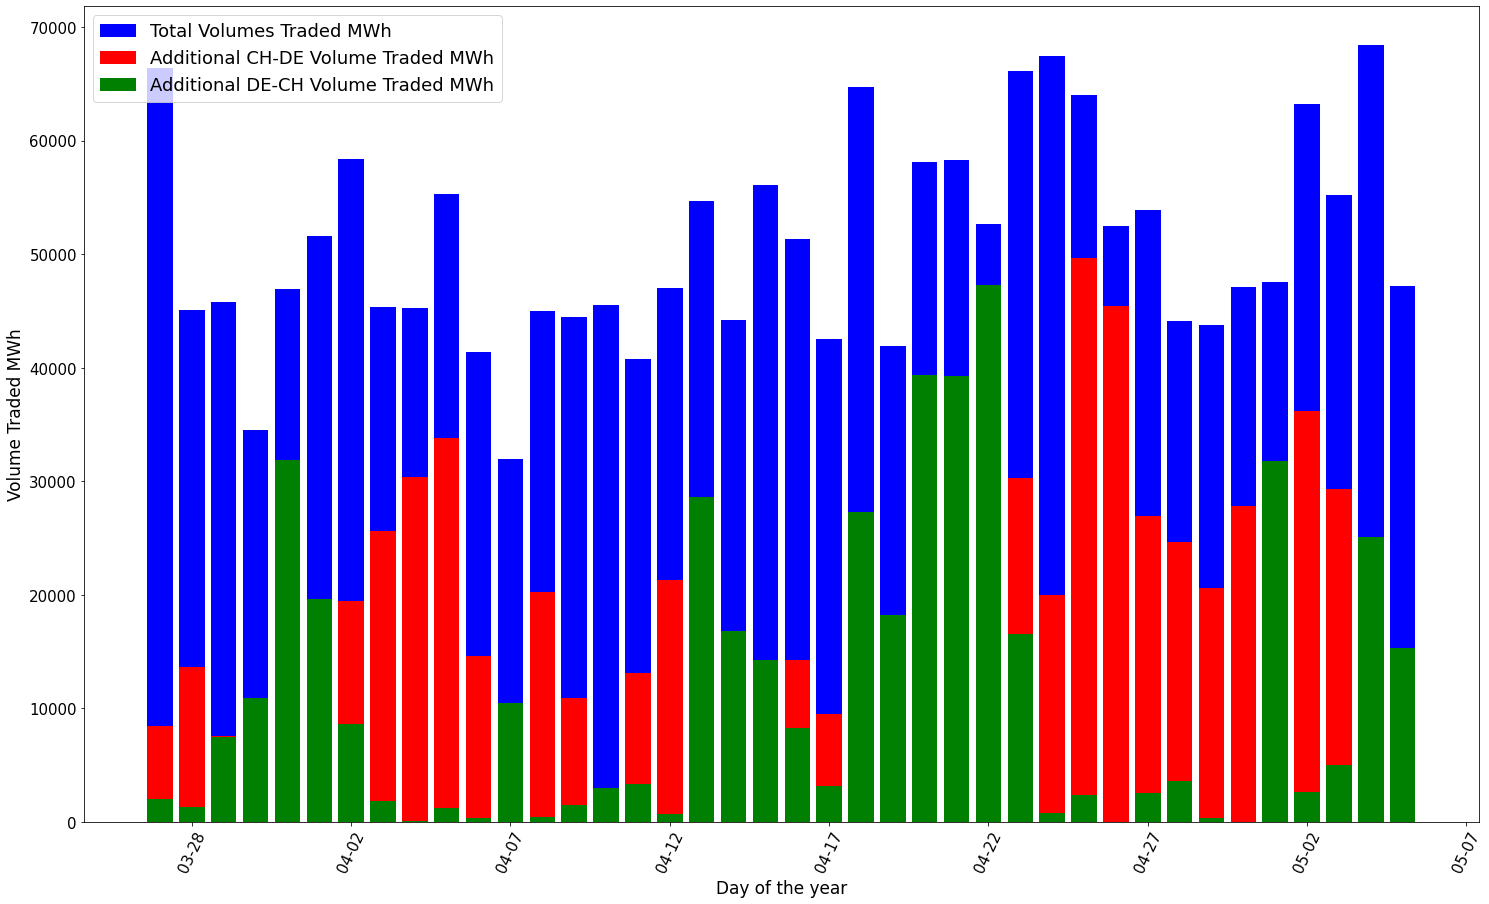

In [21]:
# plot
days = mdates.DayLocator(interval=5)
d_fmt = mdates.DateFormatter('%m-%d')
    
    
fig, ax = plt.subplots(figsize=(25, 15))
ax.bar(pd.to_datetime(df_summary['time']), 
       df_summary['Total Volume Traded'], 
       color='blue',
       label='Total Volumes Traded MWh')

ax.bar(pd.to_datetime(df_summary['time']),
       df_summary['Total Volume Traded CH-DE'], 
       color='red',
       label='Additional CH-DE Volume Traded MWh')

ax.bar(pd.to_datetime(df_summary['time']),
       df_summary['Total Volume Traded DE-CH'], 
       color='green',
       label='Additional DE-CH Volume Traded MWh')

ax.set_xlabel('Day of the year', size=17)
ax.set_ylabel('Volume Traded MWh', size=17)
ax.legend()

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(d_fmt)
ax.xaxis.set_tick_params(rotation=65)
# ax.set_ylim([0,20000])
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)